# Exploratory Analysis of Station Usage and Imbalance

## For interactive Sankey diagram, see http://bl.ocks.org/zwrankin/26944952b0b6bcae78107abedec5498f 

## Conclusions
- **Only 2% of stations have a daily imbalance of >5 bikes**, and only 2 have imbalance of >20 bikes per day. 
- To be honest, I thought station imbalance would be a bigger issue. Coming from Seattle, watching bikes pile up at the bottom of hills, I assumed you'd see daily imbalance. In Chicago, I think the bigger issue would be the daily commute, which would cause imbalances in the morning & evening. Predicting daily usage (using e.g. weather features) would be fun, but not the compelling logistical issue I intended to pursue. 
- Oddly, the imbalance is *smaller* in the summer, with no stations having daily imbalance of >20. 

In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.download_data import query_cta_stations
from src.process_data import load_cta_stations, process_station_metadata, load_station_metadata
from src.process_data import process_trip_data, load_trip_data

from src.visualization import map_stations

%matplotlib inline

In [39]:
df_stations = load_station_metadata()

In [40]:
df_stations.head()

,id,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7,online_datetime,online_month,online_year,online_duration,online_duration_days,distance_to_closest_L_station,trips_from_total,trips_to_total,trips_net_total,trips_to_per_day,trips_from_per_day,trips_net_per_day
0,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,2013-06-10,NaN,2013-06-10 10:43:00,2013-06,2013,1846 days 13:16:56,1846.0,0.006503,48144,44771,-3373,24.252979,26.080173,-1.827194
1,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,2013-06-10,NaN,2013-06-10 10:44:00,2013-06,2013,1846 days 13:15:56,1846.0,0.011236,93204,89264,-3940,48.355363,50.489707,-2.134345
2,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013,1846 days 13:13:56,1846.0,0.013429,64164,64889,725,35.151138,34.758397,0.392741
3,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013,1846 days 13:13:56,1846.0,0.000237,40652,42254,1602,22.889491,22.021668,0.867822
4,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,2013-06-10,NaN,2013-06-10 11:18:00,2013-06,2013,1846 days 12:41:56,1846.0,0.013518,67028,58458,-8570,31.667389,36.309859,-4.642470


# Exploratory Data Analysis

## Station Usage

(array([419., 108.,  38.,   9.,   4.,   4.,   2.,   0.,   0.,   1.]),
 array([9.16230366e-03, 1.90627717e+01, 3.81163811e+01, 5.71699905e+01,
        7.62235999e+01, 9.52772093e+01, 1.14330819e+02, 1.33384428e+02,
        1.52438037e+02, 1.71491647e+02, 1.90545256e+02]),
 <a list of 10 Patch objects>)

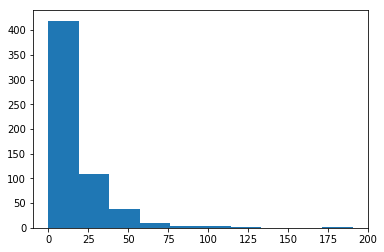

In [64]:
plt.hist(df_stations.trips_from_per_day)

In [57]:
# Map of daily station usage  
df_stations['color'] = 'black'
map_stations(df_stations, 'trips_from_per_day')

## Station Imbalance (difference between daily trips to and from a station)

(array([  1.,   0.,   1.,   3., 371., 203.,   4.,   1.,   0.,   1.]),
 array([-26.7533557 , -21.38036474, -16.00737377, -10.6343828 ,
         -5.26139183,   0.11159914,   5.48459011,  10.85758107,
         16.23057204,  21.60356301,  26.97655398]),
 <a list of 10 Patch objects>)

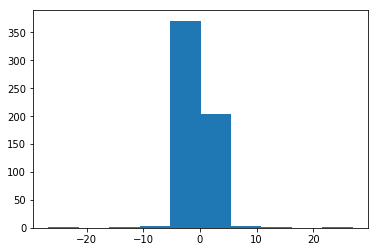

In [65]:
plt.hist(df_stations.trips_net_per_day)

In [85]:
for t in [5,10, 20]:
    p = (np.abs(df_stations.trips_net_per_day) > t).mean()
    n = (np.abs(df_stations.trips_net_per_day) > t).sum()
    print(f'only {n} stations ({100*p:.3f}%) have a net gain or loss of {t} bikes per day')

only 12 stations (2.051%) have a net gain or loss of 5 bikes per day
only 5 stations (0.855%) have a net gain or loss of 10 bikes per day
only 2 stations (0.342%) have a net gain or loss of 20 bikes per day


In [71]:
# Map of daily station imbalance  
df_stations['color'] = 'black'
df_stations.loc[df_stations.trips_net_per_day > 5, 'color'] = 'blue'
df_stations.loc[df_stations.trips_net_per_day < -5, 'color'] = 'red'
df_stations['trips_net_per_day_absval'] = np.abs(df_stations.trips_net_per_day)
map_stations(df_stations, 'trips_net_per_day_absval')

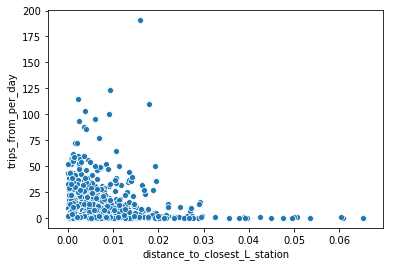

In [74]:
# Scatter of distance to L stop
sns.scatterplot('distance_to_closest_L_station', 'trips_from_per_day', 
               data=df_stations)

# Can you look at station imbalance just in the summer? Maybe it's much bigger

### Actually, it's much smaller!

In [87]:
df_trips = load_trip_data()

In [96]:
df_trips['month'] = df_trips.start_datetime.map(lambda x: x.month)

In [97]:
df_trips.month.value_counts()

6     2207315
7     2102153
8     2099817
9     1861321
5     1691017
10    1432818
4     1035113
11     827823
3      691090
12     471138
2      450638
1      398841
Name: month, dtype: int64

In [98]:
summer_dates = (df_trips.month >= 6) & (df_trips.month <= 9)
summer_dates.mean()

0.5416569847935868

In [104]:
df_trips = df_trips.loc[summer_dates]

In [105]:
df = df_stations.drop(columns=['trips_to_per_day', 'trips_from_per_day', 'trips_net_per_day',
                              'trips_from_total', 'trips_to_total', 'trips_net_total'])

trips_from = df_trips.groupby(['from_station_id']).trip_id.count().reset_index()
trips_from = trips_from.rename(columns={'from_station_id': 'id', 'trip_id': 'trips_from_total'})
df = pd.merge(df, trips_from)
trips_to = df_trips.groupby(['to_station_id']).trip_id.count().reset_index()
trips_to = trips_to.rename(columns={'to_station_id': 'id', 'trip_id': 'trips_to_total'})
df = pd.merge(df, trips_to)
df['trips_net_total'] = df.trips_to_total - df.trips_from_total
# Daily trips
df['trips_to_per_day'] = df.trips_to_total / df.online_duration_days
df['trips_from_per_day'] = df.trips_from_total / df.online_duration_days
df['trips_net_per_day'] = df.trips_net_total / df.online_duration_days

(array([  1.,   0.,   1.,  37., 537.,   6.,   1.,   1.,   0.,   1.]),
 array([-13.34284116, -10.25915683,  -7.17547249,  -4.09178816,
         -1.00810383,   2.07558051,   5.15926484,   8.24294918,
         11.32663351,  14.41031785,  17.49400218]),
 <a list of 10 Patch objects>)

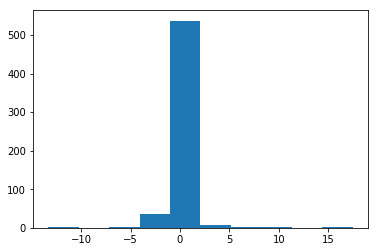

In [106]:
plt.hist(df.trips_net_per_day)

In [109]:
for t in [5,10, 20]:
    p = (np.abs(df.trips_net_per_day) > t).mean()
    n = (np.abs(df.trips_net_per_day) > t).sum()
    print(f'only {n} stations ({100*p:.3f}%) have a net gain or loss of {t} bikes per day')

only 5 stations (0.855%) have a net gain or loss of 5 bikes per day
only 3 stations (0.513%) have a net gain or loss of 10 bikes per day
only 0 stations (0.000%) have a net gain or loss of 20 bikes per day


In [107]:
# Map of daily station imbalance  
df['color'] = 'black'
df.loc[df.trips_net_per_day > 5, 'color'] = 'blue'
df.loc[df.trips_net_per_day < -5, 'color'] = 'red'
df['trips_net_per_day_absval'] = np.abs(df.trips_net_per_day)
map_stations(df, 'trips_net_per_day_absval')